In [1]:
import sys
sys.path.append('../../artools')
import artools
artools = reload(artools)

import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import scipy.optimize

## Unbounded test

Set up an constraints for an unbounded region

In [30]:
# test system 1
#A = sp.array([[-1., 0],
#              [0, -1]])
#b = sp.array([0.0, 0.0])

# test system 2
#A = sp.array([[-1., 0],
#              [0, -1],
#              [0, 1]])
#b = sp.array([0., 0, 0.5])

# test system 3
#A = sp.array([[-1., 0],
#              [0, -1],
#              [1, 0]])
#b = sp.array([0., 0, 1])

# test system 4
A = sp.array([[-1., 0],
              [0, -1],
              [-1, 1],
              [1, -1]])
b = sp.array([0., 0, 0.5, 0.5])

# test system 5 (similar to test 4, but in negative space)
#A = sp.array([[1., 0],
#              [0, 1],
#              [-1, 1],
#              [1, -1]])
#v0 = sp.array([[-0.2, -0.2],
#               [-0.2, -0.2],
#               [-0.5, -0.2],
#               [-0.2, -0.7]])
#b = sp.sum(A*v0, axis=1)

## Plot constraints

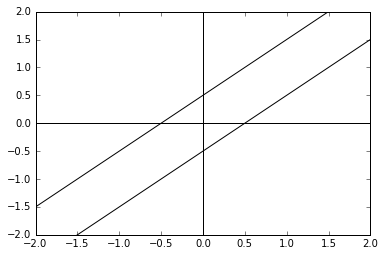

In [31]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()

artools.plot_hplanes(A, b, lims=(-2, 2), ax=ax)

ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
plt.show(fig)

## Try and visualise what's going on

c = 
[ 0.5   0.25]
b_tmp = 
[ 0.5   0.25  0.75  0.25]
D = 
[[-2.          0.        ]
 [ 0.         -4.        ]
 [-1.33333333  1.33333333]
 [ 4.         -4.        ]]


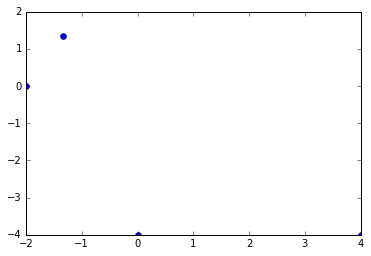

In [32]:
c = scipy.linalg.lstsq(A, b)[0]
c = sp.array([0.5, 0.25])
print "c = "
print c
if artools.out_region(c, A, b):    
    raise Exception("c is not in the region")

# calculate D matrix?
b_tmp = b - sp.dot(A, c)  # b_tmp is like a difference vector?
D = A/b_tmp[:, None]

print "b_tmp = "
print b_tmp
print "D = "
print D

fig2 = plt.figure()
ax2 = fig2.gca()

ax2.plot(D[:, 0], D[:, 1], "bo")

plt.show(fig2)

Convex hull of D points

In [33]:
k = ConvexHull(D).simplices
k

array([[1, 0],
       [1, 3],
       [2, 0],
       [2, 3]])

In [34]:
# Generate some kind of offset list of vertices offset from c vector
G = sp.zeros((len(k), D.shape[1]))
for idx in range(0, len(k)):

    # F is a matrix with rows beloning to the indices of k referencing
    # rows in matrix D??
    F = D[k[idx, :], :]

    # f is simply an nx1 column vector of ones?
    f = sp.ones((F.shape[0], 1))

    # solve the least squares problem F\f in MATLAB notation for a vector
    # that becomes a row in matrix G?
    G[idx, :] = scipy.linalg.lstsq(F, f)[0].T

# find vertices from vi = c + Gi
Vs = G + sp.tile(c.T, (G.shape[0], 1))
Vs = artools.uniqueRows(Vs)[0]
Vs

array([[  0.00000000e+00,   0.00000000e+00],
       [  5.00000000e-01,   5.55111512e-17],
       [ -1.11022302e-16,   5.00000000e-01],
       [  5.75000000e-01,   1.75000000e-01]])

Plot vertices now

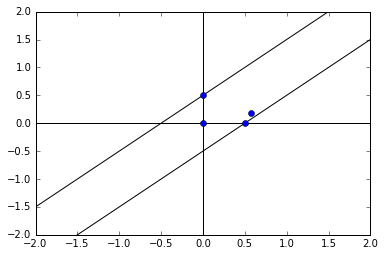

In [35]:
fig3 = plt.figure()
ax3 = fig3.gca()
ax3.hold(True)

artools.plot_hplanes(A, b, lims=(-2, 2), ax=ax3)
ax3.plot(Vs[:, 0], Vs[:, 1], "bo")

ax3.set_xlim((-2, 2))
ax3.set_ylim((-2, 2))
plt.show(fig3)

In [ ]:
def con2vert(A, b):
    '''
    Compute the V-representation of a convex polytope from a set of hyperplane
    constraints. Solve the vertex enumeration problem given inequalities of the
    form A*x <= b

    Parameters:
        A

        b

    Returns:
        Vs  (L x d) array. Each row in Vs represents an extreme point
            of the convex polytope described by A*x <= b.

    Method adapted from Michael Kelder's con2vert() MATLAB function
    http://www.mathworks.com/matlabcentral/fileexchange/7894-con2vert-constraints-to-vertices
    '''

    # check if b is a column vector with ndim=2, or (L,) array with ndim=1 only
    if b.ndim == 2:
        b = b.flatten()

    # attempt to find an interior point in the feasible region
    c = scipy.linalg.lstsq(A, b)[0]

    # if c is out of the region or on the polytope boundary, try to find a new
    # c
    num_tries = 0
    while out_region(c, A, b) or sp.any(sp.dot(A, c) - b == 0.0):

        plt.plot(c[0], c[1], "ks")

        num_tries += 1
        if num_tries > 20:
            raise Exception("con2vert() failed to find an interior point"
                            "after 20 tries. Perhaps your constraints are"
                            "badly formed or the region is unbounded.")

        def tmp_fn(xi):
            # find the Chebyshev centre, xc, of the polytope (the
            # largest inscribed ball within the polytope with centre at xc.)

            d = sp.dot(A, xi) - b
            # ensure point actually lies within region and not just on the
            # boundary
            tmp_ks = sp.nonzero(d >= -1e-6)
            # print sum(d[tmp_ks])    #sum of errors

            # return max(d)
            return sum(d[tmp_ks])

        # print "c is not in the interior, need to solve for interior point!
        # %f" % (tmp_fn(c))

        # ignore output message
        c_guess = sp.rand(A.shape[1])
        solver_result = scipy.optimize.fmin(tmp_fn, c_guess, disp=False)
        c = solver_result

    # calculate D matrix?
    b_tmp = b - sp.dot(A, c)  # b_tmp is like a difference vector?
    D = A / b_tmp[:, None]

    # find indices of convex hull belonging to D?
    k = scipy.spatial.ConvexHull(D).simplices

    # Generate some kind of offset list of vertices offset from c vector
    G = sp.zeros((len(k), D.shape[1]))
    for idx in range(0, len(k)):

        # F is a matrix with rows beloning to the indices of k referencing
        # rows in matrix D??
        F = D[k[idx, :], :]

        # f is simply an nx1 column vector of ones?
        f = sp.ones((F.shape[0], 1))

        # solve the least squares problem F\f in MATLAB notation for a vector
        # that becomes a row in matrix G?
        G[idx, :] = scipy.linalg.lstsq(F, f)[0].T

    # find vertices from vi = c + Gi
    Vs = G + sp.tile(c.T, (G.shape[0], 1))
    Vs = uniqueRows(Vs)[0]

    return Vs